In [1]:
import numpy as np
import pandas as pd
import librosa
import json
import os
import joblib
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

# ---------------------------
# Configurable parameters
# ---------------------------
rating_threshold = 3.0         
use_secondary_labels = True    
secondary_label_weight = 0.5   # Weight for secondary label examples 
perc_threshold = 90.0          # Percentile for adaptive thresholding in feature extraction (for binary mask features)
n_mels = 128                   # Number of mel bands for spectrogram features
sr = 32000                     # Sample rate for audio loading (Hz)
# XGBoost hyperparameters (can be tuned further as needed):
xgb_params = {
    "objective": "binary:logistic",
    "use_label_encoder": False,   
    "eval_metric": "logloss",     
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 0.1,
    "n_jobs": -1,
    "random_state": 42
}

# Determine if GPU is available for XGBoost
use_gpu = False
if os.environ.get('CUDA_VISIBLE_DEVICES') not in (None, '', '-1'):
    use_gpu = True
if use_gpu:
    xgb_params["tree_method"] = "gpu_hist"
else:
    xgb_params["tree_method"] = "hist"


# Load and preprocess metadata

metadata_path = '/kaggle/input/birdclef-2025/train_metadata.csv'
if not os.path.exists(metadata_path):
    # In case the metadata file has a different name
    metadata_path = '/kaggle/input/birdclef-2025/train.csv'
df = pd.read_csv(metadata_path)
# Filter out low-rated recordings (rating < 3, excluding 0 which may indicate unrated):contentReference[oaicite:9]{index=9}
if 'rating' in df.columns:
    df = df[~((df['rating'] < rating_threshold) & (df['rating'] != 0))]
# Reset index after filtering
df.reset_index(drop=True, inplace=True)

# Extract useful columns (assuming typical BirdCLEF metadata format)
# We'll assume columns: 'species_id' (numeric ID for species), 'primary_label' or 'common_name', 
# 'secondary_labels', 'latitude', 'longitude', 'filename' or 'file_id', 'collection'
species_id_col = 'species_id' if 'species_id' in df.columns else 'primary_label'
filename_col = 'filename' if 'filename' in df.columns else 'file_id' if 'file_id' in df.columns else 'recording_id'
if filename_col is None:
    # Attempt to find a column that looks like file name or ID
    for col in ['file_id', 'recording_id', 'filename']:
        if col in df.columns:
            filename_col = col
            break

# Parse secondary labels from string to list (if present and not already list)
if 'secondary_labels' in df.columns:
    # The secondary_labels might be a string of list (like "['species1','species2']")
    def parse_secondary(x):
        if pd.isna(x) or x == '[]':
            return []
        # Remove brackets and quotes, split by comma
        # e.g. "['sp1','sp2']" -> ['sp1','sp2']
        try:
            import ast
            labels = ast.literal_eval(x)
            if isinstance(labels, list):
                return labels
        except Exception:
            pass
        # Fallback: strip brackets and quotes manually
        s = x.strip("[]")
        if not s:
            return []
        return [lab.strip().strip("'\"") for lab in s.split(',')]
    df['secondary_labels'] = df['secondary_labels'].apply(parse_secondary)
else:
    # If no secondary_labels column, create an empty list column
    df['secondary_labels'] = [[] for _ in range(len(df))]

# One-hot encode collection type if available
collection_types = []
if 'collection' in df.columns:
    collection_types = sorted(df['collection'].dropna().unique())
    # Create one-hot columns for each collection type (CSA, XC, iNat, etc.)
    for c in collection_types:
        df[f'collection_{c}'] = (df['collection'] == c).astype(int)
else:
    # If no collection column, assume all one type or create dummy column
    df['collection_unknown'] = 1
    collection_types = ['unknown']

# Feature extraction function

def extract_features(audio_path, collection_type=None):
    """
    Extract features from an audio file:
      - Log-mel spectrogram statistics (mean & std of each mel band in dB)
      - Binary mask features: fraction of time frames in each band above a dynamic threshold
      - Additional contextual features: (latitude, longitude, one-hot collection)
    Returns feature vector as numpy array.
    """
    # Load audio
    try:
        y, _ = librosa.load(audio_path, sr=sr, mono=True)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None
    # If CSA collection, trim first 10 seconds to remove potential speech
    if collection_type == 'CSA':
        if len(y) > 10 * sr:
            y = y[int(10*sr):]

    # (For simplicity, using full audio; in practice, could split long audio to 5-10s segments for training)
    # Compute mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=2.0)
    # Convert to log-magnitude (dB):contentReference[oaicite:12]{index=12}
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Compute per-band statistics

    band_means = mel_db.mean(axis=1)
    band_stds = mel_db.std(axis=1)
    # Adaptive binary mask features using percentile threshold
    thresh = np.percentile(mel, perc_threshold)  # threshold on linear mel power values
    # Create binary mask of time-frequency bins above threshold
    mask = (mel > thresh)
    # Fraction of time frames (columns) where each band has energy above threshold
    # (i.e., how often each frequency band is "active" with strong signal)
    frac_active = mask.sum(axis=1) / mask.shape[1]
    # Concatenate all features
    features = np.concatenate([band_means, band_stds, frac_active])
    return features

# Pre-extract features for all recordings to avoid repeated file I/O for each species.
# We will store features in a dict keyed by the index or file ID.
print("Extracting features from all training audio...")
features_dict = {}

for idx, row in tqdm(df.iterrows(), total=len(df), desc="🔍 Extracting features"):
    file_id = row[filename_col]
    species_primary = row[species_id_col]
    lat = row.get('latitude', 0.0) or 0.0
    lon = row.get('longitude', 0.0) or 0.0
    coll = row.get('collection', None)

    audio_path = f"/kaggle/input/birdclef-2025/train_audio/{file_id}"
    if not os.path.exists(audio_path):
        print(f"Audio file for ID {file_id} not found, skipping.")
        continue

    feat = extract_features(audio_path, collection_type=coll)
    if feat is None:
        continue

    context_feats = [lat, lon]
    for c in collection_types:
        context_feats.append(1 if (row.get('collection') == c or c == 'unknown') else 0)

    full_features = np.concatenate([feat, np.array(context_feats, dtype=float)])
    features_dict[file_id] = {
        "species_primary": species_primary,
        "features": full_features,
        "secondary_labels": row['secondary_labels']
    }

print(f"Feature extraction completed. Extracted features for {len(features_dict)} recordings.")
# Determine feature vector length (for consistency in model training)
feature_length = len(next(iter(features_dict.values()))['features'])


# Training one model per species

species_list = sorted(df[species_id_col].unique())
models = {}
metrics = {}  # to store CV metrics for leaderboard
print("Training a model for each species...")
for species in tqdm(species_list, desc="🧠 Training per-species models"):
    # Prepare training data for this species
    X = []
    y = []
    sample_w = []  # sample weights
    for file_id, data in features_dict.items():
        # Label determination for this species:
        primary_label = data["species_primary"]
        sec_labels = data["secondary_labels"]
        # Positive if species is primary or (if using secondary) present in secondary list
        is_positive = (primary_label == species) or (use_secondary_labels and (species in sec_labels))
        label = 1 if is_positive else 0
        # Only include sample if we can extract features (features exist in dict)
        feat = data["features"]
        if feat is None:
            continue
        X.append(feat)
        y.append(label)
        # Determine sample weight
        if label == 1:
            # primary vs secondary
            if primary_label == species:
                w = 1.0
            else:
                # species in secondary labels only
                w = secondary_label_weight
        else:
            w = 1.0
        sample_w.append(w)
    X = np.array(X)
    y = np.array(y, dtype=int)
    sample_w = np.array(sample_w, dtype=float)
    if X.size == 0 or len(np.unique(y)) < 2:
        # If we have no data or only one class present (no positives or no negatives)
        # we cannot train a meaningful model. Skip or continue to next species.
        print(f"Skipping species {species}: insufficient training data or only one class present.")
        continue
    # Balance class weights: scale positives vs negatives so that total positive weight == total negative weight:contentReference[oaicite:13]{index=13}
    total_pos_w = sample_w[y == 1].sum()
    total_neg_w = sample_w[y == 0].sum()
    if total_pos_w == 0 or total_neg_w == 0:
        # In case no positives or no negatives (shouldn't happen due to check above)
        scale_factor = 1.0
    else:
        scale_factor = total_neg_w / total_pos_w
    # Apply scaling to positive samples' weights
    sample_w[y == 1] *= scale_factor
    # Stratified K-Fold cross-validation (with at most 5 splits, adjust if few positives):contentReference[oaicite:14]{index=14}
    n_pos = np.sum(y == 1)
    # Use min(5, n_pos, n_samples) splits, but at least 2 if possible
    n_splits = 5
    if n_pos < n_splits or len(y) < n_splits:
        n_splits = max(2, min(n_pos, len(y), 5))
    # If still n_splits is 1 (meaning n_pos == 1 or n_samples == 1), we handle separately
    if n_splits < 2:
        # Train on all data (no valid CV possible)
        print(f"Species {species}: only 1 positive sample, training on full data without CV.")
        model = __import__('xgboost').XGBClassifier(**xgb_params)
        model.fit(X, y, sample_weight=sample_w)
        models[species] = model
        metrics[species] = {"auc": None, "f1": None}
        continue
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    aucs = []
    f1s = []
    fold = 1
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_val = X[train_idx], X[test_idx]
        y_train, y_val = y[train_idx], y[test_idx]
        w_train = sample_w[train_idx]
        # Train model on this fold
        model = __import__('xgboost').XGBClassifier(**xgb_params)
        model.fit(X_train, y_train, sample_weight=w_train)
        # Predict on validation fold
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        # Compute ROC AUC for this fold
        try:
            auc = roc_auc_score(y_val, y_pred_prob)
        except ValueError:
            # If an error (e.g., all y_val are same class), skip AUC
            auc = None
        # Compute F1 score (we need a threshold to binarize probabilities; use 0.5 by default)
        y_pred_label = (y_pred_prob >= 0.5).astype(int)
        try:
            f1 = f1_score(y_val, y_pred_label, zero_division=0)
        except ValueError:
            f1 = None
        if auc is not None:
            aucs.append(auc)
        if f1 is not None:
            f1s.append(f1)
        fold += 1
    # Aggregate CV results
    mean_auc = np.mean(aucs) if aucs else None
    mean_f1 = np.mean(f1s) if f1s else None
    # Train final model on full data (using all samples) to use for inference/storage
    final_model = __import__('xgboost').XGBClassifier(**xgb_params)
    final_model.fit(X, y, sample_weight=sample_w)
    models[species] = final_model
    metrics[species] = {"auc": float(mean_auc) if mean_auc is not None else None,
                        "f1": float(mean_f1) if mean_f1 is not None else None}
    print(f"Trained model for species {species}. CV AUC={mean_auc:.3f}, F1={mean_f1:.3f}")
# End of species loop


# Save outputs (models and leaderboard metrics)

# Save all models in one dictionary using joblib
joblib.dump(models, "birdclef_models.joblib")
print("Saved all models to birdclef_models.joblib")
# Create leaderboard JSON (sorted by AUC descending for convenience)
leaderboard = []
for species, res in sorted(metrics.items(), key=lambda x: (x[1]['auc'] is not None, x[1]['auc']), reverse=True):
    entry = {"species": species, "auc": res['auc'], "f1": res['f1']}
    leaderboard.append(entry)
with open("leaderboard.json", "w") as f:
    json.dump(leaderboard, f, indent=2)
print("Saved CV metrics leaderboard to leaderboard.json")

Extracting features from all training audio...


🔍 Extracting features: 100%|██████████| 27128/27128 [1:05:14<00:00,  6.93it/s]


Feature extraction completed. Extracted features for 27128 recordings.
Training a model for each species...


🧠 Training per-species models:   0%|          | 1/206 [00:11<38:11, 11.18s/it]

Trained model for species 1139490. CV AUC=0.998, F1=0.000


🧠 Training per-species models:   1%|          | 2/206 [00:28<51:16, 15.08s/it]

Trained model for species 1192948. CV AUC=0.997, F1=0.000


🧠 Training per-species models:   1%|▏         | 3/206 [00:43<49:58, 14.77s/it]

Trained model for species 1194042. CV AUC=0.997, F1=0.000


🧠 Training per-species models:   2%|▏         | 4/206 [01:06<1:00:18, 17.91s/it]

Trained model for species 126247. CV AUC=0.990, F1=0.533


🧠 Training per-species models:   2%|▏         | 5/206 [01:29<1:06:23, 19.82s/it]

Trained model for species 1346504. CV AUC=0.998, F1=0.333


🧠 Training per-species models:   3%|▎         | 6/206 [01:49<1:06:31, 19.96s/it]

Trained model for species 134933. CV AUC=0.976, F1=0.250


🧠 Training per-species models:   3%|▎         | 7/206 [02:13<1:11:00, 21.41s/it]

Trained model for species 135045. CV AUC=0.962, F1=0.633


🧠 Training per-species models:   4%|▍         | 8/206 [02:28<1:03:19, 19.19s/it]

Trained model for species 1462711. CV AUC=0.999, F1=0.000


🧠 Training per-species models:   4%|▍         | 9/206 [02:51<1:07:16, 20.49s/it]

Trained model for species 1462737. CV AUC=1.000, F1=0.447


🧠 Training per-species models:   5%|▍         | 10/206 [03:13<1:08:23, 20.93s/it]

Trained model for species 1564122. CV AUC=1.000, F1=0.667


🧠 Training per-species models:   5%|▌         | 11/206 [03:23<56:59, 17.54s/it]  

Trained model for species 21038. CV AUC=0.940, F1=0.000


🧠 Training per-species models:   6%|▌         | 12/206 [03:32<48:46, 15.08s/it]

Trained model for species 21116. CV AUC=0.727, F1=0.000


🧠 Training per-species models:   6%|▋         | 13/206 [04:06<1:06:24, 20.64s/it]

Trained model for species 21211. CV AUC=0.992, F1=0.771


🧠 Training per-species models:   7%|▋         | 14/206 [04:42<1:21:09, 25.36s/it]

Trained model for species 22333. CV AUC=0.972, F1=0.485


🧠 Training per-species models:   7%|▋         | 15/206 [05:22<1:34:18, 29.63s/it]

Trained model for species 22973. CV AUC=0.966, F1=0.365


🧠 Training per-species models:   8%|▊         | 16/206 [05:58<1:40:19, 31.68s/it]

Trained model for species 22976. CV AUC=0.984, F1=0.330


🧠 Training per-species models:   8%|▊         | 17/206 [06:27<1:37:23, 30.92s/it]

Trained model for species 24272. CV AUC=0.808, F1=0.400


🧠 Training per-species models:   9%|▊         | 18/206 [06:46<1:25:45, 27.37s/it]

Trained model for species 24292. CV AUC=0.996, F1=0.000


🧠 Training per-species models:   9%|▉         | 19/206 [07:15<1:26:46, 27.84s/it]

Trained model for species 24322. CV AUC=0.926, F1=0.000


🧠 Training per-species models:  10%|▉         | 20/206 [07:56<1:38:33, 31.79s/it]

Trained model for species 41663. CV AUC=0.996, F1=0.594


🧠 Training per-species models:  10%|█         | 21/206 [08:06<1:17:05, 25.00s/it]

Trained model for species 41778. CV AUC=0.449, F1=0.000


🧠 Training per-species models:  11%|█         | 22/206 [08:26<1:12:34, 23.67s/it]

Trained model for species 41970. CV AUC=0.742, F1=0.000


🧠 Training per-species models:  11%|█         | 23/206 [08:53<1:15:24, 24.72s/it]

Trained model for species 42007. CV AUC=0.961, F1=0.433


🧠 Training per-species models:  12%|█▏        | 24/206 [09:03<1:01:19, 20.22s/it]

Trained model for species 42087. CV AUC=0.741, F1=0.000


🧠 Training per-species models:  12%|█▏        | 25/206 [09:14<52:16, 17.33s/it]  

Trained model for species 42113. CV AUC=0.278, F1=0.000


🧠 Training per-species models:  13%|█▎        | 26/206 [09:37<57:14, 19.08s/it]

Trained model for species 46010. CV AUC=0.653, F1=0.000


🧠 Training per-species models:  13%|█▎        | 27/206 [09:47<49:11, 16.49s/it]

Trained model for species 47067. CV AUC=0.640, F1=0.000


🧠 Training per-species models:  14%|█▎        | 28/206 [09:56<42:25, 14.30s/it]

Trained model for species 476537. CV AUC=0.990, F1=0.000


🧠 Training per-species models:  14%|█▍        | 29/206 [10:21<51:27, 17.44s/it]

Trained model for species 476538. CV AUC=0.995, F1=0.733


🧠 Training per-species models:  15%|█▍        | 30/206 [10:47<58:38, 19.99s/it]

Trained model for species 48124. CV AUC=0.999, F1=0.450


🧠 Training per-species models:  15%|█▌        | 31/206 [11:16<1:06:28, 22.79s/it]

Trained model for species 50186. CV AUC=0.999, F1=0.510


🧠 Training per-species models:  16%|█▌        | 32/206 [11:57<1:21:59, 28.27s/it]

Trained model for species 517119. CV AUC=0.972, F1=0.635


🧠 Training per-species models:  16%|█▌        | 33/206 [12:16<1:13:07, 25.36s/it]

Trained model for species 523060. CV AUC=1.000, F1=0.250


🧠 Training per-species models:  17%|█▋        | 34/206 [12:27<1:00:40, 21.16s/it]

Trained model for species 528041. CV AUC=0.999, F1=0.000


🧠 Training per-species models:  17%|█▋        | 35/206 [12:57<1:07:10, 23.57s/it]

Trained model for species 52884. CV AUC=0.999, F1=0.523


🧠 Training per-species models:  17%|█▋        | 36/206 [13:21<1:07:15, 23.74s/it]

Trained model for species 548639. CV AUC=1.000, F1=0.333


🧠 Training per-species models:  18%|█▊        | 37/206 [13:51<1:12:21, 25.69s/it]

Trained model for species 555086. CV AUC=0.971, F1=0.405


🧠 Training per-species models:  18%|█▊        | 38/206 [14:17<1:11:54, 25.68s/it]

Trained model for species 555142. CV AUC=0.939, F1=0.000


🧠 Training per-species models:  19%|█▉        | 39/206 [14:48<1:16:22, 27.44s/it]

Trained model for species 566513. CV AUC=0.922, F1=0.336


🧠 Training per-species models:  19%|█▉        | 40/206 [14:57<1:00:48, 21.98s/it]

Trained model for species 64862. CV AUC=0.999, F1=0.500


🧠 Training per-species models:  20%|█▉        | 41/206 [15:25<1:04:45, 23.55s/it]

Trained model for species 65336. CV AUC=0.955, F1=0.000


🧠 Training per-species models:  20%|██        | 42/206 [15:54<1:09:07, 25.29s/it]

Trained model for species 65344. CV AUC=0.964, F1=0.394


🧠 Training per-species models:  21%|██        | 43/206 [16:23<1:11:40, 26.39s/it]

Trained model for species 65349. CV AUC=0.987, F1=0.313


🧠 Training per-species models:  21%|██▏       | 44/206 [16:58<1:18:17, 29.00s/it]

Trained model for species 65373. CV AUC=0.939, F1=0.259


🧠 Training per-species models:  22%|██▏       | 45/206 [17:12<1:05:39, 24.47s/it]

Trained model for species 65419. CV AUC=0.944, F1=0.000


🧠 Training per-species models:  22%|██▏       | 46/206 [17:54<1:19:22, 29.77s/it]

Trained model for species 65448. CV AUC=0.986, F1=0.576


🧠 Training per-species models:  23%|██▎       | 47/206 [18:20<1:15:31, 28.50s/it]

Trained model for species 65547. CV AUC=0.921, F1=0.000


🧠 Training per-species models:  23%|██▎       | 48/206 [18:47<1:13:57, 28.08s/it]

Trained model for species 65962. CV AUC=0.990, F1=0.280


🧠 Training per-species models:  24%|██▍       | 49/206 [18:58<1:00:17, 23.04s/it]

Trained model for species 66016. CV AUC=1.000, F1=0.333


🧠 Training per-species models:  24%|██▍       | 50/206 [19:07<48:59, 18.84s/it]  

Trained model for species 66531. CV AUC=0.549, F1=0.000


🧠 Training per-species models:  25%|██▍       | 51/206 [19:16<41:07, 15.92s/it]

Trained model for species 66578. CV AUC=0.514, F1=0.000


🧠 Training per-species models:  25%|██▌       | 52/206 [19:40<46:51, 18.26s/it]

Trained model for species 66893. CV AUC=0.956, F1=0.600


🧠 Training per-species models:  26%|██▌       | 53/206 [19:49<39:18, 15.42s/it]

Trained model for species 67082. CV AUC=0.660, F1=0.000


🧠 Training per-species models:  26%|██▌       | 54/206 [20:14<46:57, 18.54s/it]

Trained model for species 67252. CV AUC=0.927, F1=0.540


🧠 Training per-species models:  27%|██▋       | 55/206 [20:37<49:58, 19.86s/it]

Trained model for species 714022. CV AUC=1.000, F1=0.733


🧠 Training per-species models:  27%|██▋       | 56/206 [21:01<52:30, 21.00s/it]

Trained model for species 715170. CV AUC=1.000, F1=0.776


🧠 Training per-species models:  28%|██▊       | 57/206 [21:25<54:22, 21.90s/it]

Trained model for species 787625. CV AUC=0.910, F1=0.267


🧠 Training per-species models:  28%|██▊       | 58/206 [21:35<45:28, 18.44s/it]

Trained model for species 81930. CV AUC=0.329, F1=0.000


🧠 Training per-species models:  29%|██▊       | 59/206 [21:51<42:54, 17.51s/it]

Trained model for species 868458. CV AUC=0.750, F1=0.500


🧠 Training per-species models:  29%|██▉       | 60/206 [22:15<47:11, 19.39s/it]

Trained model for species 963335. CV AUC=1.000, F1=0.100


🧠 Training per-species models:  30%|██▉       | 61/206 [23:01<1:06:17, 27.43s/it]

Trained model for species amakin1. CV AUC=0.863, F1=0.241


🧠 Training per-species models:  30%|███       | 62/206 [24:05<1:32:27, 38.53s/it]

Trained model for species amekes. CV AUC=0.964, F1=0.612


🧠 Training per-species models:  31%|███       | 63/206 [24:37<1:27:23, 36.66s/it]

Trained model for species ampkin1. CV AUC=0.841, F1=0.000


🧠 Training per-species models:  31%|███       | 64/206 [25:24<1:34:03, 39.74s/it]

Trained model for species anhing. CV AUC=0.954, F1=0.491


🧠 Training per-species models:  32%|███▏      | 65/206 [26:09<1:37:07, 41.33s/it]

Trained model for species babwar. CV AUC=0.998, F1=0.825


🧠 Training per-species models:  32%|███▏      | 66/206 [26:43<1:30:54, 38.96s/it]

Trained model for species bafibi1. CV AUC=0.911, F1=0.107


🧠 Training per-species models:  33%|███▎      | 67/206 [27:49<1:49:20, 47.20s/it]

Trained model for species banana. CV AUC=0.957, F1=0.584


🧠 Training per-species models:  33%|███▎      | 68/206 [28:47<1:56:04, 50.46s/it]

Trained model for species baymac. CV AUC=0.963, F1=0.489


🧠 Training per-species models:  33%|███▎      | 69/206 [29:49<2:02:48, 53.79s/it]

Trained model for species bbwduc. CV AUC=0.939, F1=0.526


🧠 Training per-species models:  34%|███▍      | 70/206 [30:30<1:53:22, 50.02s/it]

Trained model for species bicwre1. CV AUC=0.942, F1=0.407


🧠 Training per-species models:  34%|███▍      | 71/206 [31:27<1:57:01, 52.01s/it]

Trained model for species bkcdon. CV AUC=0.915, F1=0.322


🧠 Training per-species models:  35%|███▍      | 72/206 [32:27<2:01:36, 54.45s/it]

Trained model for species bkmtou1. CV AUC=0.990, F1=0.790


🧠 Training per-species models:  35%|███▌      | 73/206 [33:34<2:09:16, 58.32s/it]

Trained model for species blbgra1. CV AUC=0.923, F1=0.453


🧠 Training per-species models:  36%|███▌      | 74/206 [34:20<1:59:54, 54.50s/it]

Trained model for species blbwre1. CV AUC=0.966, F1=0.396


🧠 Training per-species models:  36%|███▋      | 75/206 [35:07<1:54:14, 52.33s/it]

Trained model for species blcant4. CV AUC=0.959, F1=0.402


🧠 Training per-species models:  37%|███▋      | 76/206 [35:46<1:44:56, 48.44s/it]

Trained model for species blchaw1. CV AUC=0.884, F1=0.157


🧠 Training per-species models:  37%|███▋      | 77/206 [36:29<1:40:23, 46.69s/it]

Trained model for species blcjay1. CV AUC=0.952, F1=0.283


🧠 Training per-species models:  38%|███▊      | 78/206 [36:59<1:28:59, 41.71s/it]

Trained model for species blctit1. CV AUC=0.768, F1=0.000


🧠 Training per-species models:  38%|███▊      | 79/206 [37:58<1:39:14, 46.89s/it]

Trained model for species blhpar1. CV AUC=0.926, F1=0.347


🧠 Training per-species models:  39%|███▉      | 80/206 [38:39<1:34:40, 45.08s/it]

Trained model for species blkvul. CV AUC=0.873, F1=0.185


🧠 Training per-species models:  39%|███▉      | 81/206 [39:40<1:43:37, 49.74s/it]

Trained model for species bobfly1. CV AUC=0.858, F1=0.239


🧠 Training per-species models:  40%|███▉      | 82/206 [40:16<1:34:43, 45.84s/it]

Trained model for species bobher1. CV AUC=0.920, F1=0.286


🧠 Training per-species models:  40%|████      | 83/206 [41:04<1:35:16, 46.47s/it]

Trained model for species brtpar1. CV AUC=0.912, F1=0.218


🧠 Training per-species models:  41%|████      | 84/206 [41:34<1:24:15, 41.43s/it]

Trained model for species bubcur1. CV AUC=0.924, F1=0.357


🧠 Training per-species models:  41%|████▏     | 85/206 [42:36<1:36:01, 47.61s/it]

Trained model for species bubwre1. CV AUC=0.926, F1=0.388


🧠 Training per-species models:  42%|████▏     | 86/206 [43:14<1:29:37, 44.82s/it]

Trained model for species bucmot3. CV AUC=0.937, F1=0.296


🧠 Training per-species models:  42%|████▏     | 87/206 [44:15<1:38:21, 49.59s/it]

Trained model for species bugtan. CV AUC=0.912, F1=0.342


🧠 Training per-species models:  43%|████▎     | 88/206 [45:19<1:45:45, 53.78s/it]

Trained model for species butsal1. CV AUC=0.918, F1=0.335


🧠 Training per-species models:  43%|████▎     | 89/206 [46:03<1:39:25, 50.98s/it]

Trained model for species cargra1. CV AUC=0.963, F1=0.369


🧠 Training per-species models:  44%|████▎     | 90/206 [46:55<1:39:25, 51.43s/it]

Trained model for species cattyr. CV AUC=0.921, F1=0.389


🧠 Training per-species models:  44%|████▍     | 91/206 [47:54<1:42:24, 53.43s/it]

Trained model for species chbant1. CV AUC=0.983, F1=0.570


🧠 Training per-species models:  45%|████▍     | 92/206 [48:45<1:40:17, 52.79s/it]

Trained model for species chfmac1. CV AUC=0.949, F1=0.491


🧠 Training per-species models:  45%|████▌     | 93/206 [49:25<1:32:05, 48.89s/it]

Trained model for species cinbec1. CV AUC=0.943, F1=0.238


🧠 Training per-species models:  46%|████▌     | 94/206 [50:02<1:24:33, 45.29s/it]

Trained model for species cocher1. CV AUC=0.926, F1=0.156


🧠 Training per-species models:  46%|████▌     | 95/206 [50:55<1:28:14, 47.70s/it]

Trained model for species cocwoo1. CV AUC=0.959, F1=0.414


🧠 Training per-species models:  47%|████▋     | 96/206 [51:34<1:22:44, 45.13s/it]

Trained model for species colara1. CV AUC=0.925, F1=0.111


🧠 Training per-species models:  47%|████▋     | 97/206 [52:24<1:24:30, 46.52s/it]

Trained model for species colcha1. CV AUC=0.984, F1=0.598


🧠 Training per-species models:  48%|████▊     | 98/206 [53:34<1:36:44, 53.75s/it]

Trained model for species compau. CV AUC=0.963, F1=0.627


🧠 Training per-species models:  48%|████▊     | 99/206 [54:36<1:40:01, 56.09s/it]

Trained model for species compot1. CV AUC=0.982, F1=0.665


🧠 Training per-species models:  49%|████▊     | 100/206 [55:37<1:41:48, 57.63s/it]

Trained model for species cotfly1. CV AUC=0.884, F1=0.321


🧠 Training per-species models:  49%|████▉     | 101/206 [56:18<1:31:51, 52.49s/it]

Trained model for species crbtan1. CV AUC=0.953, F1=0.099


🧠 Training per-species models:  50%|████▉     | 102/206 [57:11<1:31:27, 52.77s/it]

Trained model for species crcwoo1. CV AUC=0.907, F1=0.276


🧠 Training per-species models:  50%|█████     | 103/206 [57:49<1:22:57, 48.33s/it]

Trained model for species crebob1. CV AUC=0.907, F1=0.059


🧠 Training per-species models:  50%|█████     | 104/206 [58:32<1:19:23, 46.70s/it]

Trained model for species cregua1. CV AUC=0.947, F1=0.354


🧠 Training per-species models:  51%|█████     | 105/206 [59:31<1:24:37, 50.27s/it]

Trained model for species creoro1. CV AUC=0.883, F1=0.303


🧠 Training per-species models:  51%|█████▏    | 106/206 [1:00:19<1:22:41, 49.62s/it]

Trained model for species eardov1. CV AUC=0.943, F1=0.459


🧠 Training per-species models:  52%|█████▏    | 107/206 [1:01:04<1:19:50, 48.39s/it]

Trained model for species fotfly. CV AUC=0.888, F1=0.147


🧠 Training per-species models:  52%|█████▏    | 108/206 [1:01:51<1:18:19, 47.95s/it]

Trained model for species gohman1. CV AUC=0.952, F1=0.389


🧠 Training per-species models:  53%|█████▎    | 109/206 [1:02:32<1:14:19, 45.97s/it]

Trained model for species grasal4. CV AUC=0.955, F1=0.190


🧠 Training per-species models:  53%|█████▎    | 110/206 [1:03:17<1:12:58, 45.61s/it]

Trained model for species grbhaw1. CV AUC=0.830, F1=0.101


🧠 Training per-species models:  54%|█████▍    | 111/206 [1:04:10<1:15:34, 47.73s/it]

Trained model for species greani1. CV AUC=0.897, F1=0.325


🧠 Training per-species models:  54%|█████▍    | 112/206 [1:05:07<1:19:11, 50.55s/it]

Trained model for species greegr. CV AUC=0.982, F1=0.696


🧠 Training per-species models:  55%|█████▍    | 113/206 [1:05:55<1:17:22, 49.92s/it]

Trained model for species greibi1. CV AUC=0.964, F1=0.510


🧠 Training per-species models:  55%|█████▌    | 114/206 [1:07:00<1:23:18, 54.33s/it]

Trained model for species grekis. CV AUC=0.839, F1=0.354


🧠 Training per-species models:  56%|█████▌    | 115/206 [1:07:39<1:15:26, 49.75s/it]

Trained model for species grepot1. CV AUC=0.951, F1=0.285


🧠 Training per-species models:  56%|█████▋    | 116/206 [1:08:21<1:10:52, 47.25s/it]

Trained model for species gretin1. CV AUC=0.969, F1=0.511


🧠 Training per-species models:  57%|█████▋    | 117/206 [1:09:09<1:10:47, 47.73s/it]

Trained model for species grnkin. CV AUC=0.839, F1=0.132


🧠 Training per-species models:  57%|█████▋    | 118/206 [1:09:41<1:03:03, 42.99s/it]

Trained model for species grysee1. CV AUC=0.841, F1=0.057


🧠 Training per-species models:  58%|█████▊    | 119/206 [1:10:38<1:08:19, 47.12s/it]

Trained model for species gybmar. CV AUC=0.860, F1=0.151


🧠 Training per-species models:  58%|█████▊    | 120/206 [1:11:41<1:14:29, 51.97s/it]

Trained model for species gycwor1. CV AUC=0.937, F1=0.583


🧠 Training per-species models:  59%|█████▊    | 121/206 [1:12:28<1:11:12, 50.26s/it]

Trained model for species labter1. CV AUC=0.941, F1=0.402


🧠 Training per-species models:  59%|█████▉    | 122/206 [1:13:31<1:15:39, 54.05s/it]

Trained model for species laufal1. CV AUC=0.964, F1=0.731


🧠 Training per-species models:  60%|█████▉    | 123/206 [1:14:20<1:12:44, 52.58s/it]

Trained model for species leagre. CV AUC=0.864, F1=0.127


🧠 Training per-species models:  60%|██████    | 124/206 [1:15:19<1:14:48, 54.74s/it]

Trained model for species linwoo1. CV AUC=0.852, F1=0.282


🧠 Training per-species models:  61%|██████    | 125/206 [1:16:21<1:16:45, 56.86s/it]

Trained model for species littin1. CV AUC=0.947, F1=0.580


🧠 Training per-species models:  61%|██████    | 126/206 [1:17:08<1:11:48, 53.86s/it]

Trained model for species mastit1. CV AUC=0.847, F1=0.202


🧠 Training per-species models:  62%|██████▏   | 127/206 [1:17:59<1:09:32, 52.81s/it]

Trained model for species neocor. CV AUC=0.923, F1=0.340


🧠 Training per-species models:  62%|██████▏   | 128/206 [1:18:25<58:24, 44.93s/it]  

Trained model for species norscr1. CV AUC=0.932, F1=0.347


🧠 Training per-species models:  63%|██████▎   | 129/206 [1:18:58<52:53, 41.22s/it]

Trained model for species olipic1. CV AUC=0.976, F1=0.307


🧠 Training per-species models:  63%|██████▎   | 130/206 [1:19:51<57:01, 45.02s/it]

Trained model for species orcpar. CV AUC=0.974, F1=0.470


🧠 Training per-species models:  64%|██████▎   | 131/206 [1:20:33<54:56, 43.96s/it]

Trained model for species palhor2. CV AUC=0.895, F1=0.328


🧠 Training per-species models:  64%|██████▍   | 132/206 [1:21:31<59:23, 48.15s/it]

Trained model for species paltan1. CV AUC=0.890, F1=0.221


🧠 Training per-species models:  65%|██████▍   | 133/206 [1:22:26<1:01:09, 50.27s/it]

Trained model for species pavpig2. CV AUC=0.925, F1=0.498


🧠 Training per-species models:  65%|██████▌   | 134/206 [1:23:04<55:49, 46.52s/it]  

Trained model for species piepuf1. CV AUC=0.912, F1=0.166


🧠 Training per-species models:  66%|██████▌   | 135/206 [1:24:07<1:00:56, 51.50s/it]

Trained model for species pirfly1. CV AUC=0.853, F1=0.254


🧠 Training per-species models:  66%|██████▌   | 136/206 [1:24:38<52:48, 45.26s/it]  

Trained model for species piwtyr1. CV AUC=0.759, F1=0.000


🧠 Training per-species models:  67%|██████▋   | 137/206 [1:25:35<56:05, 48.77s/it]

Trained model for species plbwoo1. CV AUC=0.887, F1=0.133


🧠 Training per-species models:  67%|██████▋   | 138/206 [1:25:55<45:35, 40.23s/it]

Trained model for species plctan1. CV AUC=0.820, F1=0.000


🧠 Training per-species models:  67%|██████▋   | 139/206 [1:26:32<43:45, 39.18s/it]

Trained model for species plukit1. CV AUC=0.892, F1=0.000


🧠 Training per-species models:  68%|██████▊   | 140/206 [1:27:25<47:48, 43.47s/it]

Trained model for species purgal2. CV AUC=0.885, F1=0.273


🧠 Training per-species models:  68%|██████▊   | 141/206 [1:28:08<46:50, 43.23s/it]

Trained model for species ragmac1. CV AUC=0.967, F1=0.348


🧠 Training per-species models:  69%|██████▉   | 142/206 [1:28:48<45:02, 42.23s/it]

Trained model for species rebbla1. CV AUC=0.903, F1=0.203


🧠 Training per-species models:  69%|██████▉   | 143/206 [1:29:34<45:39, 43.48s/it]

Trained model for species recwoo1. CV AUC=0.931, F1=0.190


🧠 Training per-species models:  70%|██████▉   | 144/206 [1:30:33<49:43, 48.13s/it]

Trained model for species rinkin1. CV AUC=0.888, F1=0.277


🧠 Training per-species models:  70%|███████   | 145/206 [1:31:36<53:17, 52.42s/it]

Trained model for species roahaw. CV AUC=0.879, F1=0.327


🧠 Training per-species models:  71%|███████   | 146/206 [1:32:06<45:57, 45.96s/it]

Trained model for species rosspo1. CV AUC=0.925, F1=0.209


🧠 Training per-species models:  71%|███████▏  | 147/206 [1:32:45<42:53, 43.62s/it]

Trained model for species royfly1. CV AUC=0.945, F1=0.145


🧠 Training per-species models:  72%|███████▏  | 148/206 [1:33:36<44:28, 46.01s/it]

Trained model for species rtlhum. CV AUC=0.965, F1=0.380


🧠 Training per-species models:  72%|███████▏  | 149/206 [1:34:16<41:47, 44.00s/it]

Trained model for species rubsee1. CV AUC=0.927, F1=0.242


🧠 Training per-species models:  73%|███████▎  | 150/206 [1:35:01<41:31, 44.49s/it]

Trained model for species rufmot1. CV AUC=0.977, F1=0.419


🧠 Training per-species models:  73%|███████▎  | 151/206 [1:36:00<44:48, 48.88s/it]

Trained model for species rugdov. CV AUC=0.936, F1=0.409


🧠 Training per-species models:  74%|███████▍  | 152/206 [1:36:55<45:40, 50.76s/it]

Trained model for species rumfly1. CV AUC=0.869, F1=0.158


🧠 Training per-species models:  74%|███████▍  | 153/206 [1:37:41<43:32, 49.28s/it]

Trained model for species ruther1. CV AUC=0.867, F1=0.151


🧠 Training per-species models:  75%|███████▍  | 154/206 [1:38:40<45:06, 52.06s/it]

Trained model for species rutjac1. CV AUC=0.879, F1=0.231


🧠 Training per-species models:  75%|███████▌  | 155/206 [1:39:08<38:11, 44.92s/it]

Trained model for species rutpuf1. CV AUC=0.860, F1=0.100


🧠 Training per-species models:  76%|███████▌  | 156/206 [1:40:13<42:26, 50.93s/it]

Trained model for species saffin. CV AUC=0.922, F1=0.419


🧠 Training per-species models:  76%|███████▌  | 157/206 [1:40:40<35:39, 43.66s/it]

Trained model for species sahpar1. CV AUC=0.858, F1=0.000


🧠 Training per-species models:  77%|███████▋  | 158/206 [1:41:22<34:32, 43.19s/it]

Trained model for species savhaw1. CV AUC=0.911, F1=0.070


🧠 Training per-species models:  77%|███████▋  | 159/206 [1:42:16<36:31, 46.62s/it]

Trained model for species secfly1. CV AUC=0.931, F1=0.390


🧠 Training per-species models:  78%|███████▊  | 160/206 [1:42:44<31:27, 41.03s/it]

Trained model for species shghum1. CV AUC=0.907, F1=0.500


🧠 Training per-species models:  78%|███████▊  | 161/206 [1:43:31<31:59, 42.66s/it]

Trained model for species shtfly1. CV AUC=0.940, F1=0.221


🧠 Training per-species models:  79%|███████▊  | 162/206 [1:44:33<35:35, 48.54s/it]

Trained model for species smbani. CV AUC=0.875, F1=0.297


🧠 Training per-species models:  79%|███████▉  | 163/206 [1:45:19<34:11, 47.71s/it]

Trained model for species snoegr. CV AUC=0.917, F1=0.352


🧠 Training per-species models:  80%|███████▉  | 164/206 [1:46:17<35:36, 50.86s/it]

Trained model for species sobtyr1. CV AUC=0.895, F1=0.309


🧠 Training per-species models:  80%|████████  | 165/206 [1:47:20<37:07, 54.34s/it]

Trained model for species socfly1. CV AUC=0.906, F1=0.338


🧠 Training per-species models:  81%|████████  | 166/206 [1:48:19<37:18, 55.97s/it]

Trained model for species solsan. CV AUC=0.943, F1=0.463


🧠 Training per-species models:  81%|████████  | 167/206 [1:49:23<37:56, 58.37s/it]

Trained model for species soulap1. CV AUC=0.930, F1=0.602


🧠 Training per-species models:  82%|████████▏ | 168/206 [1:50:01<32:59, 52.08s/it]

Trained model for species spbwoo1. CV AUC=0.857, F1=0.131


🧠 Training per-species models:  82%|████████▏ | 169/206 [1:50:58<33:05, 53.67s/it]

Trained model for species speowl1. CV AUC=0.957, F1=0.550


🧠 Training per-species models:  83%|████████▎ | 170/206 [1:51:37<29:29, 49.15s/it]

Trained model for species spepar1. CV AUC=0.982, F1=0.403


🧠 Training per-species models:  83%|████████▎ | 171/206 [1:52:26<28:36, 49.04s/it]

Trained model for species srwswa1. CV AUC=0.904, F1=0.217


🧠 Training per-species models:  83%|████████▎ | 172/206 [1:53:27<29:51, 52.70s/it]

Trained model for species stbwoo2. CV AUC=0.941, F1=0.388


🧠 Training per-species models:  84%|████████▍ | 173/206 [1:54:29<30:32, 55.53s/it]

Trained model for species strcuc1. CV AUC=0.916, F1=0.517


🧠 Training per-species models:  84%|████████▍ | 174/206 [1:55:31<30:37, 57.43s/it]

Trained model for species strfly1. CV AUC=0.856, F1=0.206


🧠 Training per-species models:  85%|████████▍ | 175/206 [1:56:24<28:59, 56.11s/it]

Trained model for species strher. CV AUC=0.931, F1=0.525


🧠 Training per-species models:  85%|████████▌ | 176/206 [1:57:22<28:23, 56.77s/it]

Trained model for species strowl1. CV AUC=0.851, F1=0.162


🧠 Training per-species models:  86%|████████▌ | 177/206 [1:58:01<24:48, 51.34s/it]

Trained model for species tbsfin1. CV AUC=0.959, F1=0.315


🧠 Training per-species models:  86%|████████▋ | 178/206 [1:58:57<24:37, 52.78s/it]

Trained model for species thbeup1. CV AUC=0.910, F1=0.178


🧠 Training per-species models:  87%|████████▋ | 179/206 [1:59:40<22:27, 49.89s/it]

Trained model for species thlsch3. CV AUC=0.974, F1=0.375


🧠 Training per-species models:  87%|████████▋ | 180/206 [2:00:49<24:05, 55.59s/it]

Trained model for species trokin. CV AUC=0.914, F1=0.520


🧠 Training per-species models:  88%|████████▊ | 181/206 [2:01:53<24:11, 58.06s/it]

Trained model for species tropar. CV AUC=0.931, F1=0.501


🧠 Training per-species models:  88%|████████▊ | 182/206 [2:02:56<23:48, 59.51s/it]

Trained model for species trsowl. CV AUC=0.953, F1=0.551


🧠 Training per-species models:  89%|████████▉ | 183/206 [2:03:21<18:54, 49.35s/it]

Trained model for species turvul. CV AUC=0.879, F1=0.000


🧠 Training per-species models:  89%|████████▉ | 184/206 [2:04:01<17:01, 46.43s/it]

Trained model for species verfly. CV AUC=0.888, F1=0.053


🧠 Training per-species models:  90%|████████▉ | 185/206 [2:04:54<16:54, 48.30s/it]

Trained model for species watjac1. CV AUC=0.915, F1=0.224


🧠 Training per-species models:  90%|█████████ | 186/206 [2:05:53<17:12, 51.64s/it]

Trained model for species wbwwre1. CV AUC=0.938, F1=0.396


🧠 Training per-species models:  91%|█████████ | 187/206 [2:06:38<15:45, 49.74s/it]

Trained model for species whbant1. CV AUC=0.968, F1=0.522


🧠 Training per-species models:  91%|█████████▏| 188/206 [2:07:34<15:25, 51.43s/it]

Trained model for species whbman1. CV AUC=0.931, F1=0.327


🧠 Training per-species models:  92%|█████████▏| 189/206 [2:08:21<14:14, 50.28s/it]

Trained model for species whfant1. CV AUC=0.963, F1=0.469


🧠 Training per-species models:  92%|█████████▏| 190/206 [2:08:54<12:00, 45.04s/it]

Trained model for species whmtyr1. CV AUC=0.920, F1=0.113


🧠 Training per-species models:  93%|█████████▎| 191/206 [2:09:59<12:46, 51.11s/it]

Trained model for species whtdov. CV AUC=0.926, F1=0.586


🧠 Training per-species models:  93%|█████████▎| 192/206 [2:10:41<11:17, 48.37s/it]

Trained model for species whttro1. CV AUC=0.974, F1=0.428


🧠 Training per-species models:  94%|█████████▎| 193/206 [2:11:19<09:48, 45.28s/it]

Trained model for species whwswa1. CV AUC=0.869, F1=0.029


🧠 Training per-species models:  94%|█████████▍| 194/206 [2:11:49<08:08, 40.68s/it]

Trained model for species woosto. CV AUC=0.883, F1=0.384


🧠 Training per-species models:  95%|█████████▍| 195/206 [2:12:43<08:11, 44.66s/it]

Trained model for species y00678. CV AUC=0.870, F1=0.283


🧠 Training per-species models:  95%|█████████▌| 196/206 [2:13:44<08:14, 49.42s/it]

Trained model for species yebela1. CV AUC=0.885, F1=0.324


🧠 Training per-species models:  96%|█████████▌| 197/206 [2:14:39<07:39, 51.08s/it]

Trained model for species yebfly1. CV AUC=0.941, F1=0.367


🧠 Training per-species models:  96%|█████████▌| 198/206 [2:15:34<06:59, 52.44s/it]

Trained model for species yebsee1. CV AUC=0.922, F1=0.287


🧠 Training per-species models:  97%|█████████▋| 199/206 [2:16:33<06:19, 54.28s/it]

Trained model for species yecspi2. CV AUC=0.950, F1=0.499


🧠 Training per-species models:  97%|█████████▋| 200/206 [2:17:17<05:07, 51.31s/it]

Trained model for species yectyr1. CV AUC=0.861, F1=0.080


🧠 Training per-species models:  98%|█████████▊| 201/206 [2:17:58<04:00, 48.12s/it]

Trained model for species yehbla2. CV AUC=0.923, F1=0.366


🧠 Training per-species models:  98%|█████████▊| 202/206 [2:18:55<03:23, 50.75s/it]

Trained model for species yehcar1. CV AUC=0.869, F1=0.247


🧠 Training per-species models:  99%|█████████▊| 203/206 [2:19:32<02:19, 46.58s/it]

Trained model for species yelori1. CV AUC=0.946, F1=0.170


🧠 Training per-species models:  99%|█████████▉| 204/206 [2:20:36<01:43, 51.84s/it]

Trained model for species yeofly1. CV AUC=0.915, F1=0.363


🧠 Training per-species models: 100%|█████████▉| 205/206 [2:21:44<00:56, 56.85s/it]

Trained model for species yercac1. CV AUC=0.924, F1=0.327


🧠 Training per-species models: 100%|██████████| 206/206 [2:22:38<00:00, 41.55s/it]

Trained model for species ywcpar. CV AUC=0.961, F1=0.515


Saved all models to birdclef_models.joblib
Saved CV metrics leaderboard to leaderboard.json


In [3]:
import pandas as pd
import json

# Step 1: Load leaderboard
with open("leaderboard.json", "r") as f:
    leaderboard = json.load(f)

# Step 2: Convert leaderboard list of dicts into DataFrame
df = pd.DataFrame(leaderboard)

# Ensure species column is string type (consistent with train.csv)
df['species'] = df['species'].astype(str)

# Step 3: Load train.csv
train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")

# Step 4: Count number of files per species based on primary_label
train_df['primary_label'] = train_df['primary_label'].astype(str)
nfile_counts = train_df['primary_label'].value_counts().to_dict()

# Step 5: Map into leaderboard DataFrame
df['n_files_count'] = df['species'].map(nfile_counts).fillna(0).astype(int)

# Optional: sort
df = df.sort_values('species').reset_index(drop=True)

# ✅ Done
print(df)

     species       auc        f1  n_files_count
0    1139490  0.997751  0.000000              2
1    1192948  0.996866  0.000000              4
2    1194042  0.997088  0.000000              3
3     126247  0.990414  0.533333              6
4    1346504  0.998396  0.333333              5
..       ...       ...       ...            ...
201  yehcar1  0.868995  0.247034            238
202  yelori1  0.946472  0.169825             60
203  yeofly1  0.915006  0.363442            525
204  yercac1  0.924217  0.327414            302
205   ywcpar  0.960548  0.515011            142

[206 rows x 4 columns]


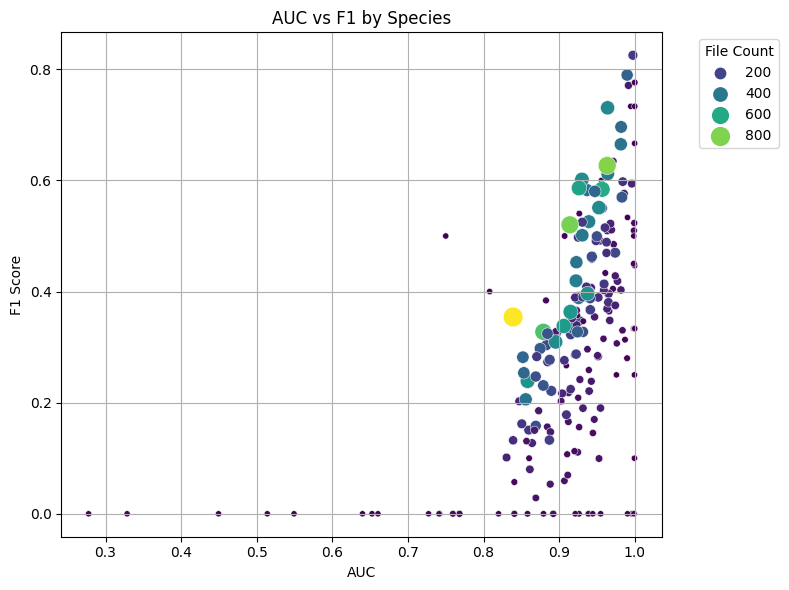

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="auc", y="f1", hue="n_files_count", palette="viridis", size="n_files_count", sizes=(20, 200))
plt.title("AUC vs F1 by Species")
plt.xlabel("AUC")
plt.ylabel("F1 Score")
plt.legend(title="File Count", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
low_f1_df = df[df["f1"] < 0.1].sort_values("f1")
print(low_f1_df[["species", "auc", "f1", "n_files_count"]].head(10))

     species       auc   f1  n_files_count
0    1139490  0.997751  0.0              2
182   turvul  0.879290  0.0             11
156  sahpar1  0.858150  0.0             14
138  plukit1  0.892214  0.0             38
137  plctan1  0.819846  0.0              6
135  piwtyr1  0.759453  0.0             19
77   blctit1  0.768201  0.0             32
62   ampkin1  0.840795  0.0             28
57     81930  0.328559  0.0              2
52     67082  0.660344  0.0              2


In [5]:
avg_auc = df["auc"].mean()
avg_f1 = df["f1"].mean()

print(f"Average AUC: {avg_auc:.3f}")
print(f"Average F1: {avg_f1:.3f}")

Average AUC: 0.911
Average F1: 0.310


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


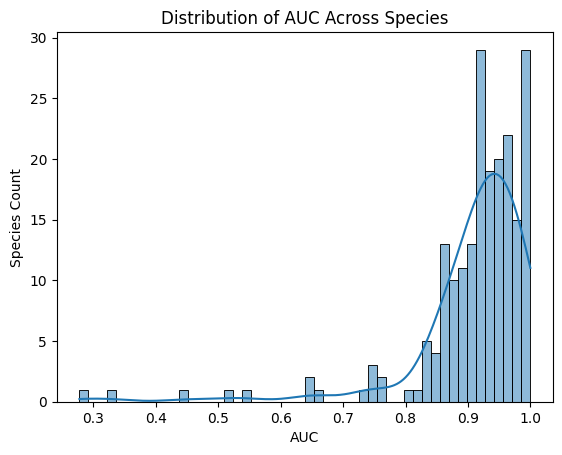

In [6]:
sns.histplot(df["auc"], bins=50, kde=True)
plt.title("Distribution of AUC Across Species")
plt.xlabel("AUC")
plt.ylabel("Species Count")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


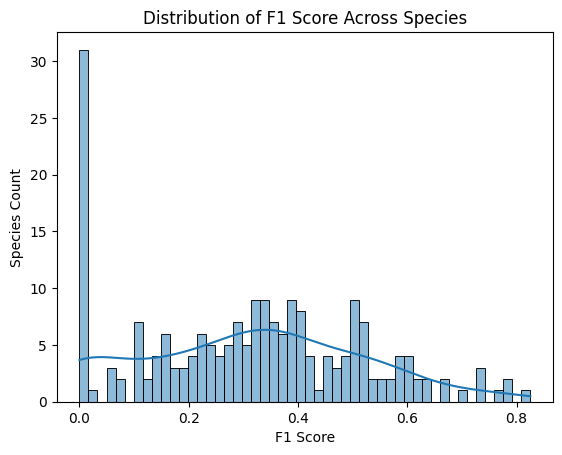

In [7]:
sns.histplot(df["f1"], bins=50, kde=True)
plt.title("Distribution of F1 Score Across Species")
plt.xlabel("F1 Score")
plt.ylabel("Species Count")
plt.show()

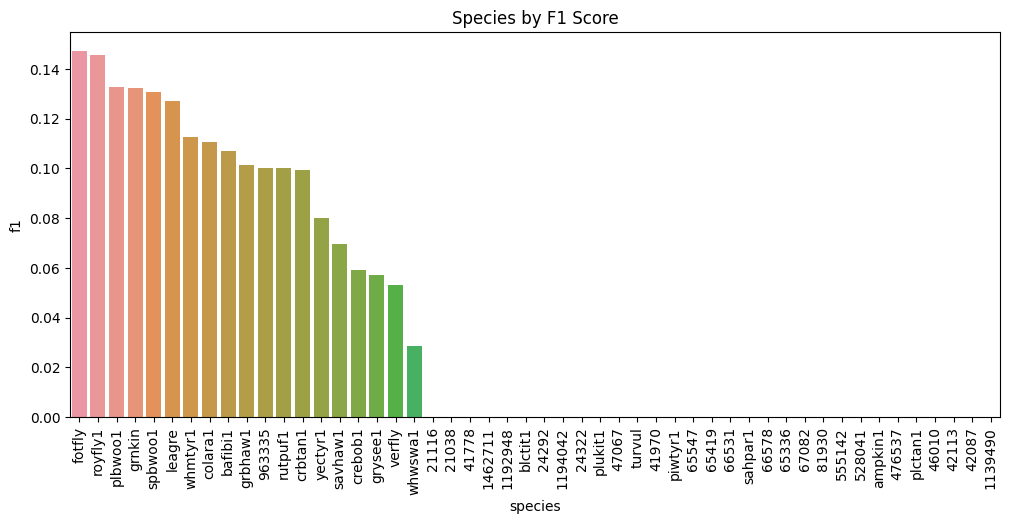

In [8]:
top_f1 = df.sort_values("f1", ascending=False).tail(50)

plt.figure(figsize=(12, 5))
sns.barplot(data=top_f1, x="species", y="f1")
plt.xticks(rotation=90)
plt.title("Species by F1 Score")
plt.show()

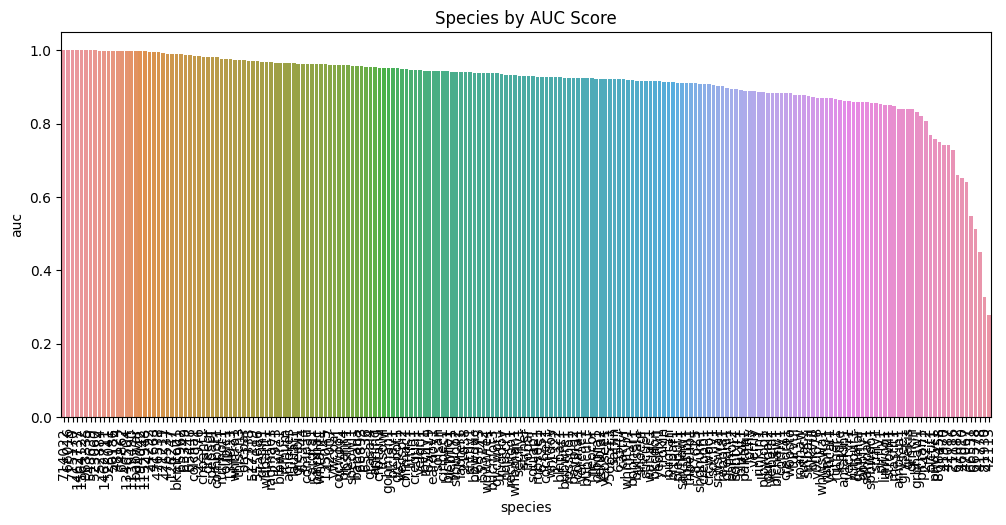

In [9]:
top_auc = df.sort_values("auc", ascending=False)

plt.figure(figsize=(12, 5))
sns.barplot(data=top_auc, x="species", y="auc")
plt.xticks(rotation=90)
plt.title("Species by AUC Score")
plt.show()

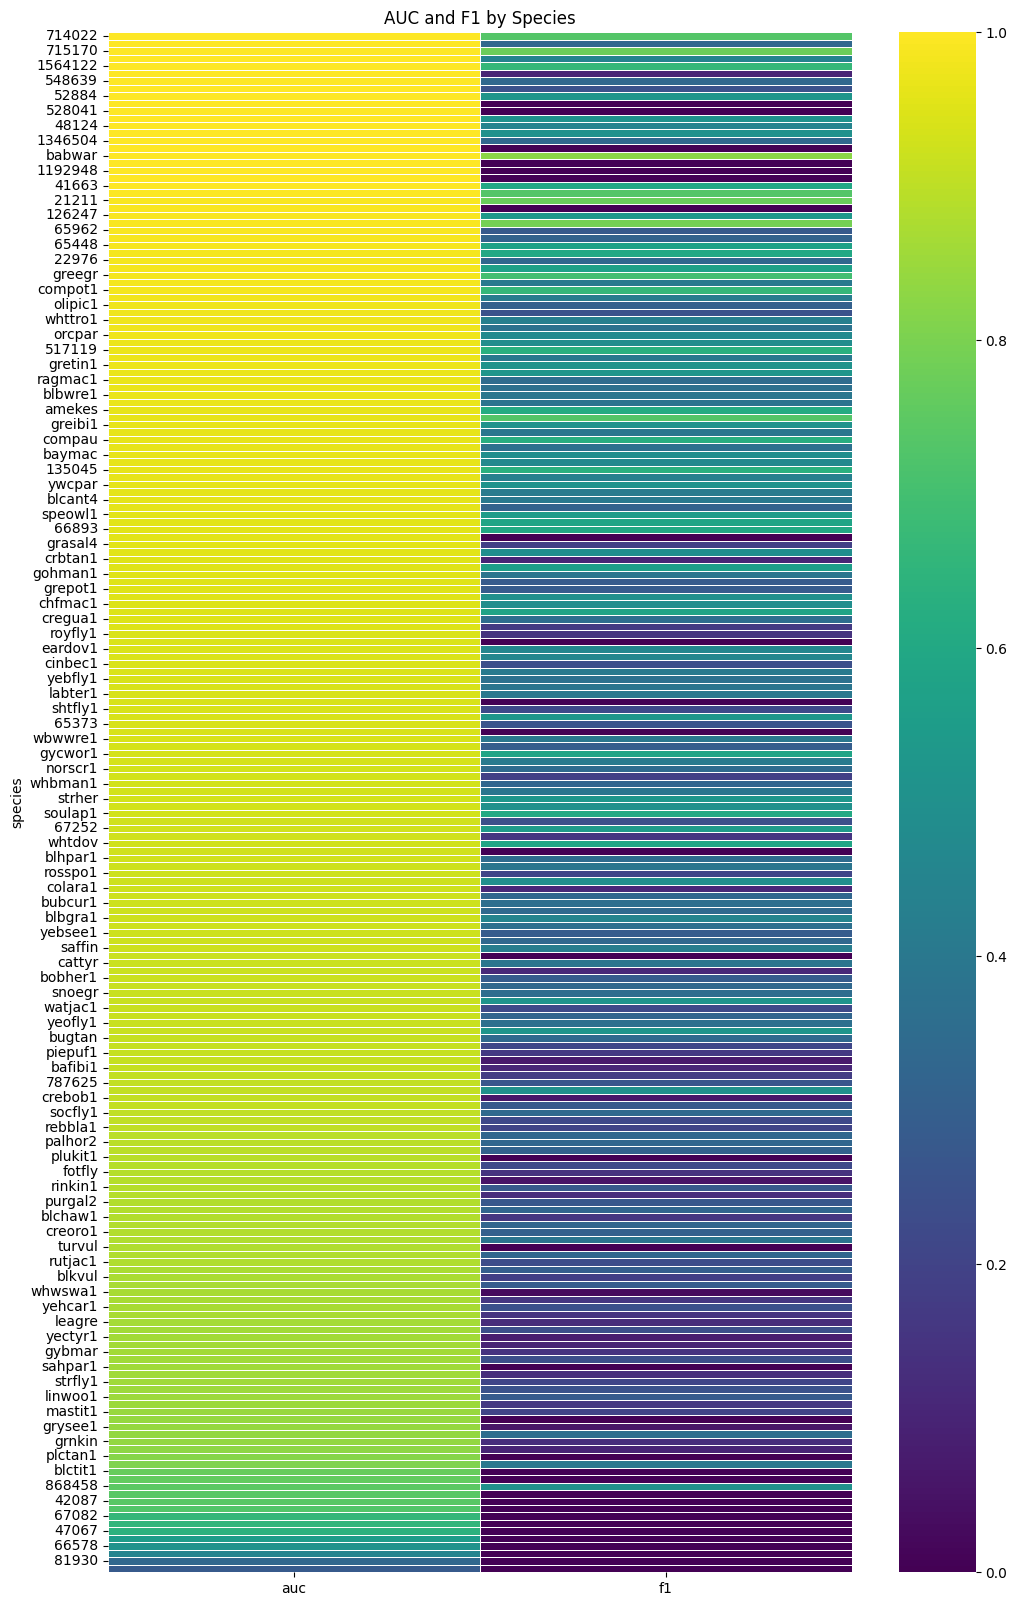

In [10]:
heatmap_df = df.set_index("species")[["auc", "f1"]].sort_values("auc", ascending=False)
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_df, annot=False, cmap="viridis", linewidths=0.5)
plt.title("AUC and F1 by Species")
plt.show()

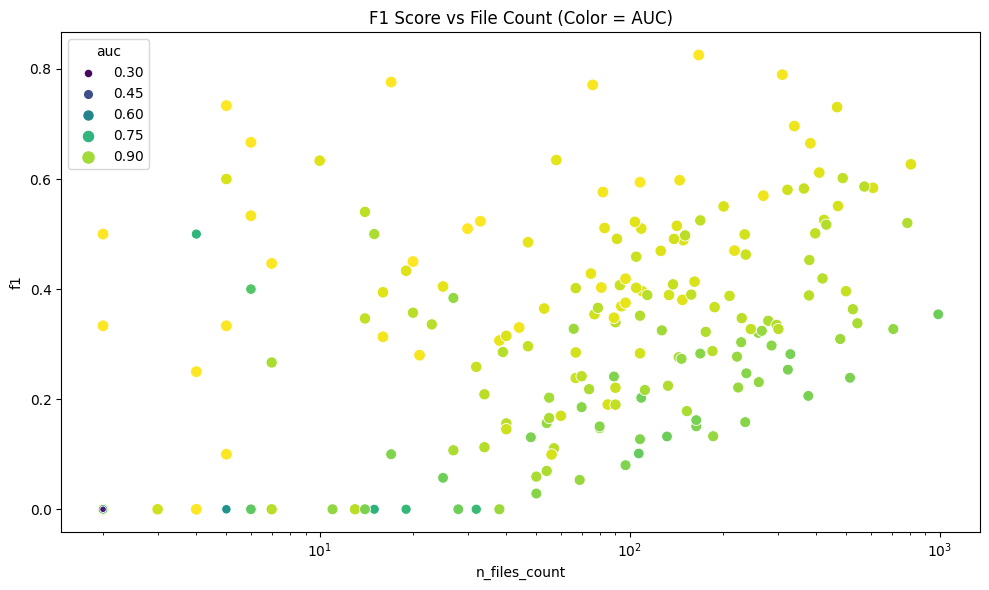

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="n_files_count", y="f1", hue="auc", size="auc", palette="viridis")
plt.title("F1 Score vs File Count (Color = AUC)")
plt.xscale("log")
plt.tight_layout()
plt.show()

In [15]:
zero_f1_species = df[df['f1'] == 0].sort_values("n_files_count")
print(f"Number of species with F1 = 0: {len(zero_f1_species)}")
print(zero_f1_species['species'])

Number of species with F1 = 0: 31
0      1139490
57       81930
52       67082
50       66578
49       66531
27      476537
26       47067
24       42113
23       42087
33      528041
20       41778
11       21116
10       21038
17       24292
2      1194042
44       65419
7      1462711
1      1192948
25       46010
40       65336
137    plctan1
37      555142
46       65547
182     turvul
18       24322
156    sahpar1
21       41970
135    piwtyr1
62     ampkin1
77     blctit1
138    plukit1
Name: species, dtype: object


In [23]:
import pandas as pd
import os

# Load original train.csv
train_path = "/kaggle/input/birdclef-2025/train.csv"
df = pd.read_csv(train_path)

# Filter rows with species to augment
zero_f1_species = [
    '1139490', '1192948', '1194042', '1462711', '21038', '21116', '24292', '24322',
    '41778', '41970', '42087', '42113', '46010', '47067', '476537', '528041',
    '555142', '65336', '65419', '65547', '66531', '66578', '67082', '81930', 'plukit1',
    'plctan1', 'piwtyr1', 'sahpar1', 'turvul', 'blctit1', 'ampkin1'
]

aug_suffixes = ["ts_0.9", "ts_1.1", "ps_up", "ps_down", "gain"]
df_to_augment = df[df["primary_label"].isin(zero_f1_species)]

# Build augmented rows
aug_rows = []
for _, row in df_to_augment.iterrows():
    base_filename = os.path.splitext(row['filename'])[0]
    for suffix in aug_suffixes:
        new_row = row.copy()
        new_row['filename'] = f"{base_filename}_{suffix}.ogg"
        aug_rows.append(new_row)

# Create DataFrame and combine
aug_df = pd.DataFrame(aug_rows)
final_df = pd.concat([df, aug_df], ignore_index=True)

# Save to new CSV
final_df.to_csv("/kaggle/working/train_augmented.csv", index=False)

In [28]:
import numpy as np
import pandas as pd
import librosa
import json
import os
import joblib
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

# ---------------------------
# Configurable parameters
# ---------------------------
target_species = [
    '1139490', '1192948', '1194042', '1462711', '21038', '21116', '24292', '24322',
    '41778', '41970', '42087', '42113', '46010', '47067', '476537', '528041',
    '555142', '65336', '65419', '65547', '66531', '66578', '67082', '81930', 'plukit1',
    'plctan1', 'piwtyr1', 'sahpar1', 'turvul', 'blctit1', 'ampkin1'
]

rating_threshold = 3.0
use_secondary_labels = True
secondary_label_weight = 0.5
perc_threshold = 90.0
n_mels = 128
sr = 32000
xgb_params = {
    "objective": "binary:logistic",
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 0.1,
    "n_jobs": -1,
    "random_state": 42
}
use_gpu = os.environ.get('CUDA_VISIBLE_DEVICES') not in (None, '', '-1')
xgb_params["tree_method"] = "gpu_hist" if use_gpu else "hist"

# ---------------------------
# Load metadata and filter
# ---------------------------
metadata_path = '/kaggle/input/birdclef-2025/train_metadata.csv'
if not os.path.exists(metadata_path):
    metadata_path = '/kaggle/input/birdclef-2025/train.csv'
df = pd.read_csv(metadata_path)

if 'rating' in df.columns:
    df = df[~((df['rating'] < rating_threshold) & (df['rating'] != 0))]

df = df[df['primary_label'].isin(target_species)].reset_index(drop=True)

if 'secondary_labels' in df.columns:
    def parse_secondary(x):
        if pd.isna(x) or x == '[]':
            return []
        try:
            import ast
            labels = ast.literal_eval(x)
            return labels if isinstance(labels, list) else []
        except Exception:
            s = x.strip("[]")
            return [lab.strip().strip("'\"") for lab in s.split(',')] if s else []
    df['secondary_labels'] = df['secondary_labels'].apply(parse_secondary)
else:
    df['secondary_labels'] = [[] for _ in range(len(df))]

collection_types = []
if 'collection' in df.columns:
    collection_types = sorted(df['collection'].dropna().unique())
    for c in collection_types:
        df[f'collection_{c}'] = (df['collection'] == c).astype(int)
else:
    df['collection_unknown'] = 1
    collection_types = ['unknown']

filename_col = None
for col in ['filename', 'file_id', 'recording_id']:
    if col in df.columns:
        filename_col = col
        break

# ---------------------------
# Feature extraction function
# ---------------------------
def extract_features(audio_path, collection_type=None):
    try:
        y, _ = librosa.load(audio_path, sr=sr, mono=True)
    except Exception as e:
        print(f"Error loading {audio_path}: {e}")
        return None
    if collection_type == 'CSA' and len(y) > 10 * sr:
        y = y[int(10 * sr):]
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, power=2.0)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    band_means = mel_db.mean(axis=1)
    band_stds = mel_db.std(axis=1)
    thresh = np.percentile(mel, perc_threshold)
    mask = (mel > thresh)
    frac_active = mask.sum(axis=1) / mask.shape[1]
    features = np.concatenate([band_means, band_stds, frac_active])
    return features

# ---------------------------
# Extract features
# ---------------------------
print("Extracting features...")
features_dict = {}
for idx, row in tqdm(df.iterrows(), total=len(df), desc="🔍 Extracting features"):
    file_id = row[filename_col]
    audio_path = f"/kaggle/input/birdclef-2025/train_audio/{file_id}"
    if not os.path.exists(audio_path):
        print(f"Missing: {audio_path}")
        continue
    feat = extract_features(audio_path, collection_type=row.get('collection'))
    if feat is None:
        continue
    lat = row.get('latitude', 0.0) or 0.0
    lon = row.get('longitude', 0.0) or 0.0
    context_feats = [lat, lon]
    for c in collection_types:
        context_feats.append(1 if row.get('collection') == c or c == 'unknown' else 0)
    full_features = np.concatenate([feat, np.array(context_feats, dtype=float)])
    features_dict[file_id] = {
        "species_primary": row['primary_label'],
        "features": full_features,
        "secondary_labels": row['secondary_labels']
    }

print(f"Extracted features for {len(features_dict)} files.")

# ---------------------------
# Train models per species
# ---------------------------
print("Training models...")
models = {}
metrics = {}
for species in tqdm(target_species, desc="🧠 Training per-species models"):
    X, y, sample_w = [], [], []
    for file_id, data in features_dict.items():
        label = 1 if data["species_primary"] == species or (use_secondary_labels and species in data["secondary_labels"]) else 0
        feat = data["features"]
        if feat is None:
            continue
        X.append(feat)
        y.append(label)
        w = 1.0 if label == 0 or data["species_primary"] == species else secondary_label_weight
        sample_w.append(w)
    X = np.array(X)
    y = np.array(y, dtype=int)
    sample_w = np.array(sample_w, dtype=float)
    if X.size == 0 or len(np.unique(y)) < 2:
        print(f"Skipping {species}: insufficient data.")
        continue
    total_pos_w = sample_w[y == 1].sum()
    total_neg_w = sample_w[y == 0].sum()
    if total_pos_w > 0 and total_neg_w > 0:
        sample_w[y == 1] *= total_neg_w / total_pos_w
    n_pos = np.sum(y == 1)
    n_splits = max(2, min(n_pos, len(y), 5))
    if n_splits < 2:
        model = __import__('xgboost').XGBClassifier(**xgb_params)
        model.fit(X, y, sample_weight=sample_w)
        models[species] = model
        metrics[species] = {"auc": None, "f1": None}
        continue
    aucs, f1s = [], []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, val_idx in skf.split(X, y):
        model = __import__('xgboost').XGBClassifier(**xgb_params)
        model.fit(X[train_idx], y[train_idx], sample_weight=sample_w[train_idx])
        y_val_pred = model.predict_proba(X[val_idx])[:, 1]
        y_val_bin = (y_val_pred >= 0.5).astype(int)
        try:
            aucs.append(roc_auc_score(y[val_idx], y_val_pred))
            f1s.append(f1_score(y[val_idx], y_val_bin))
        except Exception:
            pass
    final_model = __import__('xgboost').XGBClassifier(**xgb_params)
    final_model.fit(X, y, sample_weight=sample_w)
    models[species] = final_model
    metrics[species] = {
        "auc": float(np.mean(aucs)) if aucs else None,
        "f1": float(np.mean(f1s)) if f1s else None
    }

# ---------------------------
# Save outputs
# ---------------------------
joblib.dump(models, "birdclef_31_models.joblib")
print("✅ Saved models to birdclef_models.joblib")

with open("leaderboard_31.json", "w") as f:
    leaderboard = [{"species": s, "auc": m["auc"], "f1": m["f1"]} for s, m in metrics.items()]
    json.dump(leaderboard, f, indent=2)
print("✅ Saved leaderboard to leaderboard_updated.json")

Extracting features...


🔍 Extracting features: 100%|██████████| 196/196 [00:31<00:00,  6.30it/s]


Extracted features for 196 files.
Training models...


🧠 Training per-species models: 100%|██████████| 31/31 [00:44<00:00,  1.44s/it]

✅ Saved models to birdclef_models.joblib
✅ Saved leaderboard to leaderboard_updated.json


In [33]:
import pandas as pd
import json

# Step 1: Load leaderboard
with open("leaderboard_31.json", "r") as f:
    leaderboard = json.load(f)

# Step 2: Convert leaderboard list of dicts into DataFrame
df_updated = pd.DataFrame(leaderboard)

# Ensure species column is string type (consistent with train.csv)
df_updated['species'] = df_updated['species'].astype(str)

# Step 3: Load train.csv
train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")

# Step 4: Count number of files per species based on primary_label
train_df['primary_label'] = train_df['primary_label'].astype(str)
nfile_counts = train_df['primary_label'].value_counts().to_dict()

# Step 5: Map into leaderboard DataFrame
df_updated['n_files_count'] = df_updated['species'].map(nfile_counts).fillna(0).astype(int)

# Optional: sort
df_updated = df_updated.sort_values('species').reset_index(drop=True)

# ✅ Done
print(df_updated)

    species       auc        f1  n_files_count
0   1139490  0.855670  0.000000              2
1   1192948  0.932292  0.000000              4
2   1194042  0.664062  0.222222              3
3   1462711  0.937500  0.000000              3
4     21038  0.484536  0.000000              2
5     21116  0.487113  0.000000              2
6     24292  0.933013  0.000000              3
7     24322  0.880831  0.380000             13
8     41778  0.353093  0.000000              2
9     41970  0.828125  0.500000             15
10    42087  0.492268  0.000000              2
11    42113  0.585052  0.000000              2
12    46010  0.921188  0.000000              5
13    47067  0.445876  0.000000              2
14   476537  0.608247  0.000000              2
15   528041  0.922680  0.166667              2
16   555142  0.931579  0.400000              6
17    65336  0.757895  0.200000              6
18    65419  0.968750  0.333333              3
19    65547  0.810100  0.100000              7
20    66531  

In [40]:
import pandas as pd
import json

# Load train.csv for n_files_count
train_df = pd.read_csv("/kaggle/input/birdclef-2025/train.csv")
train_df['primary_label'] = train_df['primary_label'].astype(str)
nfile_counts = train_df['primary_label'].value_counts().to_dict()

# Load old full leaderboard (216 species, with old AUC/F1)
with open("leaderboard.json", "r") as f:
    leaderboard = json.load(f)
df = pd.DataFrame(leaderboard)
df['species'] = df['species'].astype(str)
df.set_index('species', inplace=True)

# Load new 31-species leaderboard (with updated AUC/F1)
with open("leaderboard_31.json", "r") as f:
    leaderboard_31 = json.load(f)
df_updated = pd.DataFrame(leaderboard_31)
df_updated['species'] = df_updated['species'].astype(str)
df_updated.set_index('species', inplace=True)

# Replace AUC/F1 in old leaderboard with new values for 31 species
df.update(df_updated[['auc', 'f1']])

# Add n_files_count column
df['n_files_count'] = df.index.map(nfile_counts).fillna(0).astype(int)

# Reset index and sort
df_final = df.reset_index().sort_values('species')

# Save updated full leaderboard
df_final.to_json("leaderboard_merged_full.json", orient="records", indent=2)

# ✅ Done
print(df_final)

     species       auc        f1  n_files_count
15   1139490  0.855670  0.000000              2
18   1192948  0.932292  0.000000              4
17   1194042  0.664062  0.222222              3
24    126247  0.990414  0.533333              6
14   1346504  0.998396  0.333333              5
..       ...       ...       ...            ...
170  yehcar1  0.868995  0.247034            238
79   yelori1  0.946472  0.169825             60
132  yeofly1  0.915006  0.363442            525
115  yercac1  0.924217  0.327414            302
60    ywcpar  0.960548  0.515011            142

[206 rows x 4 columns]


In [41]:
avg_auc = df_final["auc"].mean()
avg_f1 = df_final["f1"].mean()

print(f"Average AUC: {avg_auc:.3f}")
print(f"Average F1: {avg_f1:.3f}")

Average AUC: 0.904
Average F1: 0.338


In [44]:
import pandas as pd
import json

# Load old and new leaderboards
with open("leaderboard.json") as f:
    old_data = json.load(f)

with open("leaderboard_31.json") as f:
    new_data = json.load(f)

# Convert to DataFrames
df_old = pd.DataFrame(old_data)
df_new = pd.DataFrame(new_data)

# Ensure species is string
df_old['species'] = df_old['species'].astype(str)
df_new['species'] = df_new['species'].astype(str)

# Merge on species
df_merged = pd.merge(df_old, df_new, on='species', suffixes=('_old', '_new'))

# Compute deltas
df_merged['delta_auc'] = df_merged['auc_new'] - df_merged['auc_old']
df_merged['delta_f1'] = df_merged['f1_new'] - df_merged['f1_old']

# Optional: sort by biggest F1 improvement
df_merged = df_merged.sort_values(by='delta_f1', ascending=False)

# Display
print(df_merged[['species', 'auc_old', 'f1_old', 'auc_new', 'f1_new', 'delta_auc', 'delta_f1']])

    species   auc_old  f1_old   auc_new    f1_new  delta_auc  delta_f1
13  plukit1  0.892214     0.0  0.939683  0.717216   0.047468  0.717216
14   turvul  0.879290     0.0  0.973329  0.666667   0.094039  0.666667
16  ampkin1  0.840795     0.0  0.894487  0.503175   0.053693  0.503175
20    41970  0.741760     0.0  0.828125  0.500000   0.086365  0.500000
18  blctit1  0.768201     0.0  0.861243  0.452222   0.093043  0.452222
19  piwtyr1  0.759453     0.0  0.819570  0.440000   0.060117  0.440000
15  sahpar1  0.858150     0.0  0.877027  0.433333   0.018877  0.433333
10   555142  0.938500     0.0  0.931579  0.400000  -0.006921  0.400000
11    24322  0.926206     0.0  0.880831  0.380000  -0.045375  0.380000
8     65419  0.944463     0.0  0.968750  0.333333   0.024287  0.333333
17  plctan1  0.819846     0.0  0.916667  0.250000   0.096821  0.250000
3   1194042  0.997088     0.0  0.664062  0.222222  -0.333025  0.222222
7     65336  0.954904     0.0  0.757895  0.200000  -0.197009  0.200000
1    5